In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt

/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Load features and labels

In [63]:
feature_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/features.npy'
label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/labels.npy'
features = np.load(feature_path)
labels = stats.mode(np.load(label_path), axis=1)[0][:, 0]

print('Feature matrix shape:', features.shape)
print('Label matrix shape:', labels.shape)

Feature matrix shape: (128699, 170)
Label matrix shape: (128699,)


In [64]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 99967, 1.0: 28732}


# Balance classes and normailze feature matrix

In [65]:
zero_indices = np.where(labels==0)[0]
one_indices = np.where(labels==1)[0]

zero_indices = np.random.choice(zero_indices, size=one_indices.shape[0], replace=False)

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = labels[indices]
new_features = normalize(features[indices])
print('Feature matrix shape:', new_features.shape)
print('Label matrix shape:', new_labels.shape)

Feature matrix shape: (57464, 170)
Label matrix shape: (57464,)


# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#25% of the data is reserved for testing. This is done for the normalized matrix as well.
feat_train, feat_test, lbl_train, lbl_test = train_test_split(feat_matrix, lbl_vector, test_size=0.25, random_state=42)
scale_feat_train, scale_feat_test, scale_lbl_train, scale_lbl_test = train_test_split(scale_feat_matrix, lbl_vector, test_size=0.25, random_state=42)

#PCA is applied with every component so the variance ratio can be graphed.
pca = PCA(n_components=200, svd_solver='randomized', whiten=True).fit(feat_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Not normalized')


#PCA is applied to the normalized matrix so it can be compared to the standard matrix in a graph.
pca_norm = PCA(n_components=200, svd_solver='randomized', whiten=True).fit(scale_feat_train)
plt.plot(np.cumsum(pca_norm.explained_variance_ratio_), label='Normalized')

#Labeling the graph.
plt.xlabel('First n-components')
plt.title('Variance ratio of first n-components')
plt.axis([-3, 114, .8, 1.01])
# plt.axis([0, 111, 1-1e-13, 1+1e-13])
plt.legend()

# Create train set, validation set, and test set

In [66]:
num_classes = 2
split_idx0 = int(new_features.shape[0] * 0.70)
split_idx1 = int(new_features.shape[0] * 0.90)

X_train = new_features[:split_idx0]
# X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx0]

X_val = new_features[split_idx0:split_idx1]
# X_val = new_features[split_idx:]
Y_val = new_labels[split_idx0:split_idx1]

X_test = new_features[split_idx1:]
# X_val = new_features[split_idx:]
Y_test = new_labels[split_idx1:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('train data shape:', X_train.shape)
print('train label shape:', Y_train.shape)
print('val data shape:', X_val.shape)
print('val label shape:', Y_val.shape)
print('test data shape:', X_test.shape)
print('test label shape:', Y_test.shape)

train data shape: (40224, 170)
train label shape: (40224, 2)
val data shape: (11493, 170)
val label shape: (11493, 2)
test data shape: (5747, 170)
test label shape: (5747,)


# Create MLP classifier

In [87]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=features.shape[1]))
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=features.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               21888     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 130       
Total para

In [89]:
epochs = 100
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)

callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_data=(X_val, Y_val), 
              callbacks=callbacks_list)

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 40224 samples, validate on 11493 samples
Epoch 1/100
40224/40224 [==============================] - 2s 38us/step - loss: 0.7156 - acc: 0.6054 - val_loss: 0.6834 - val_acc: 0.6062

Epoch 00001: val_acc improved from -inf to 0.60620, saving model to ./DNN_Model-10Second
Epoch 2/100
40224/40224 [==============================] - 0s 10us/step - loss: 0.6710 - acc: 0.6157 - val_loss: 0.6613 - val_acc: 0.6075

Epoch 00002: val_acc improved from 0.60620 to 0.60750, saving model to ./DNN_Model-10Second
Epoch 3/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.6561 - acc: 0.6158 - val_loss: 0.6527 - val_acc: 0.6085

Epoch 00003: val_acc improved from 0.60750 to 0.60854, saving model to ./DNN_Model-10Second
Epoch 4/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.6487 - acc: 0.6207 - val_loss: 0.6431 - val_acc: 0.6184

Epoch 00004: val_acc improved from 0.60854 to 0.61838, saving model to ./DNN_Model-10Second
Epoch 5/100
40224/40224 [======

40224/40224 [==============================] - 0s 9us/step - loss: 0.5510 - acc: 0.7061 - val_loss: 0.5503 - val_acc: 0.6914

Epoch 00041: val_acc did not improve from 0.70921
Epoch 42/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5475 - acc: 0.7101 - val_loss: 0.5505 - val_acc: 0.6921

Epoch 00042: val_acc did not improve from 0.70921
Epoch 43/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5484 - acc: 0.7094 - val_loss: 0.5605 - val_acc: 0.6846

Epoch 00043: val_acc did not improve from 0.70921
Epoch 44/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5532 - acc: 0.7046 - val_loss: 0.5487 - val_acc: 0.7069

Epoch 00044: val_acc did not improve from 0.70921
Epoch 45/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5422 - acc: 0.7129 - val_loss: 0.5465 - val_acc: 0.7083

Epoch 00045: val_acc did not improve from 0.70921
Epoch 46/100
40224/40224 [==============================] - 0s 9us/s

40224/40224 [==============================] - 0s 9us/step - loss: 0.5338 - acc: 0.7156 - val_loss: 0.5486 - val_acc: 0.6928

Epoch 00083: val_acc did not improve from 0.71861
Epoch 84/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5302 - acc: 0.7186 - val_loss: 0.5384 - val_acc: 0.7154

Epoch 00084: val_acc did not improve from 0.71861
Epoch 85/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5299 - acc: 0.7200 - val_loss: 0.5367 - val_acc: 0.7117

Epoch 00085: val_acc did not improve from 0.71861
Epoch 86/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5306 - acc: 0.7165 - val_loss: 0.5378 - val_acc: 0.6976

Epoch 00086: val_acc did not improve from 0.71861
Epoch 87/100
40224/40224 [==============================] - 0s 9us/step - loss: 0.5283 - acc: 0.7181 - val_loss: 0.5394 - val_acc: 0.7189

Epoch 00087: val_acc improved from 0.71861 to 0.71887, saving model to ./DNN_Model-10Second
Epoch 88/100
40224/40224 [

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


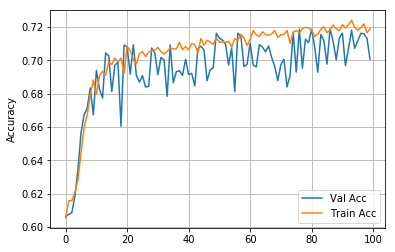

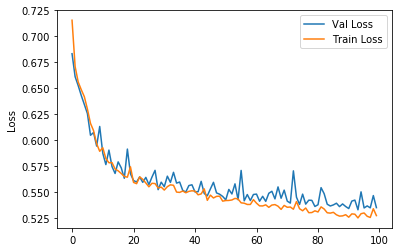

In [90]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
print(model.predict(X_test))

y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)
y_true = Y_test
confusion_matrix(y_true, y_pred)

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


[[0.21205759 0.7879424 ]
 [0.65045345 0.34954655]
 [0.8940814  0.10591856]
 ...
 [0.8469305  0.15306944]
 [0.96879625 0.03120371]
 [0.0445727  0.95542735]]
[1 0 0 ... 0 0 1]


array([[2182,  708],
       [ 890, 1967]])